In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/ritter/AD/Budding_Spectral_Analysis/code/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters
from nitorch.inference import predict

In [5]:
torch.__version__

'1.0.0'

In [6]:
gpu = 4
b = 4
num_classes = 2

dtype = np.float64

In [7]:
# Inference on different splits of the holdout set 
# holdout_h5 = h5py.File("/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/ADNI_mci_all.h5", 'r')

In [8]:
train_h5 = h5py.File("/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/ADNI_training_no_outliers.h5", 'r')
val_h5 = h5py.File("/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/ADNI_validation_no_outliers.h5", 'r')
holdout_h5 = h5py.File("/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/ADNI_holdout_no_outliers.h5", 'r')

In [9]:
X_train, y_train = train_h5['X'], train_h5['y']
X_val, y_val = val_h5['X'], val_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [10]:
mean_std_normalization = False
min_max_normalization = True

In [11]:
# normalize min-max
X_train = np.array(X_train)
X_val = np.array(X_val)
X_holdout = np.array(X_holdout)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_holdout = np.array(y_holdout)

if mean_std_normalization:
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    X_holdout = (X_holdout - mean) / std
    
if min_max_normalization:
    for i in range(len(X_train)):
        X_train[i] -= np.min(X_train[i])
        X_train[i] /= np.max(X_train[i])

    for i in range(len(X_val)):
        X_val[i] -= np.min(X_val[i])
        X_val[i] /= np.max(X_val[i])

    for i in range(len(X_holdout)):
        X_holdout[i] -= np.min(X_holdout[i])
        X_holdout[i] /= np.max(X_holdout[i])

In [12]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=np.float32, num_classes=2):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = z_factor
        self.dtype = dtype
        self.num_classes = num_classes
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label_tensor = np.zeros(shape=(self.num_classes,))
        label = self.y[idx] >= 0.5
        label = torch.LongTensor([label])
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [13]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [14]:
adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [ToTensor()]), dtype=dtype)
adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([ToTensor()]), dtype=dtype)
adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), dtype=dtype)

In [15]:
sample = adni_data_test[50]
img = sample["image"]
print(img.shape)

torch.Size([1, 182, 218, 182])


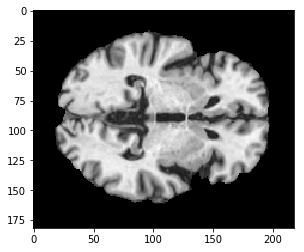

In [16]:
plt.imshow(img[0][:,:,70], cmap='gray')

# Define the classifier

In [17]:
class ClassificationModel3D(nn.Module):
    """The model we use in the paper."""

    def __init__(self, dropout=0.4, dropout2=0.4):
        nn.Module.__init__(self)
        self.Conv_1 = nn.Conv3d(1, 8, 3, bias = False)
        self.Conv_1_bn = nn.BatchNorm3d(8)
        self.Conv_1_mp = nn.MaxPool3d(2)
        self.Conv_2 = nn.Conv3d(8, 16, 3, bias = False)
        self.Conv_2_bn = nn.BatchNorm3d(16)
        self.Conv_2_mp = nn.MaxPool3d(3)
        self.Conv_3 = nn.Conv3d(16, 32, 3, bias = False)
        self.Conv_3_bn = nn.BatchNorm3d(32)
        self.Conv_3_mp = nn.MaxPool3d(2)
        self.Conv_4 = nn.Conv3d(32, 64, 3, bias = False)
        self.Conv_4_bn = nn.BatchNorm3d(64)
        self.Conv_4_mp = nn.MaxPool3d(3)
        self.dense_1 = nn.Linear(2304, 128)
        self.dense_2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout2)

    def forward(self, x):
        x = self.relu(self.Conv_1_bn(self.Conv_1(x)))
        x = self.Conv_1_mp(x)
        x = self.relu(self.Conv_2_bn(self.Conv_2(x)))
        x = self.Conv_2_mp(x)
        x = self.relu(self.Conv_3_bn(self.Conv_3(x)))
        x = self.Conv_3_mp(x)
        x = self.relu(self.Conv_4_bn(self.Conv_4(x)))
        x = self.Conv_4_mp(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.dense_1(x))
        x = self.dropout2(x)
        x = self.dense_2(x)
        return x

In [18]:
net = ClassificationModel3D().cuda(gpu)

In [19]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 368330


# Training

In [19]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(4):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = ClassificationModel3D().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.CrossEntropyLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

        train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, shuffle=True
        )
        val_loader = DataLoader(
            adni_data_val, batch_size=1, num_workers=1, shuffle=True
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        plt.imshow(img.squeeze()[:,:,70], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            prediction_type="classification"
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=60,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [20]:
num_epochs = 200
min_iters = 3
ignore_epochs = 15
normalize = False
retain_metric = accuracy_score
metrics = [accuracy_score]

In [21]:
r = 0

In [22]:
model_path = "/analysis/ritter/projects/AD/Budding_Spectral_Analysis/models/model_final"
check = ModelCheckpoint(path=model_path,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)
callbacks = [check, EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]

Starting trial 0


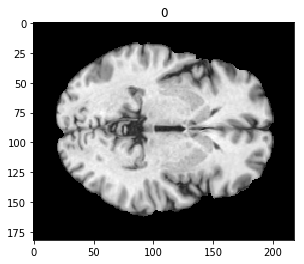

[0,    60] loss: 0.72839
[0,   120] loss: 0.68834
[0,   180] loss: 0.69668
Time elapsed: 0h:1m:37s
train accuracy_score: 54.27 %
val accuracy_score: 53.05 %
Val loss: 0.740038
[1,    60] loss: 0.69316
[1,   120] loss: 0.67421
[1,   180] loss: 0.68668
Time elapsed: 0h:3m:22s
train accuracy_score: 56.27 %
val accuracy_score: 58.54 %
Val loss: 0.652060
[2,    60] loss: 0.65718
[2,   120] loss: 0.62544
[2,   180] loss: 0.64771
Time elapsed: 0h:5m:11s
train accuracy_score: 62.93 %
val accuracy_score: 66.46 %
Val loss: 0.632588
[3,    60] loss: 0.62499
[3,   120] loss: 0.63367
[3,   180] loss: 0.60671
Time elapsed: 0h:7m:0s
train accuracy_score: 68.26 %
val accuracy_score: 58.54 %
Val loss: 0.678519
[4,    60] loss: 0.59445
[4,   120] loss: 0.56727
[4,   180] loss: 0.57104
Time elapsed: 0h:8m:48s
train accuracy_score: 70.48 %
val accuracy_score: 63.41 %
Val loss: 0.639653
[5,    60] loss: 0.57124
[5,   120] loss: 0.53869
[5,   180] loss: 0.53699
Time elapsed: 0h:10m:36s
train accuracy_score:

[46,    60] loss: 0.04107
[46,   120] loss: 0.03929
[46,   180] loss: 0.04242
Time elapsed: 1h:29m:46s
train accuracy_score: 98.78 %
val accuracy_score: 84.76 %
Val loss: 0.385451
[47,    60] loss: 0.02011
[47,   120] loss: 0.03939
[47,   180] loss: 0.06777
Time elapsed: 1h:31m:48s
train accuracy_score: 98.78 %
val accuracy_score: 85.98 %
Val loss: 0.339409
Early stopping in epoch 48
Total time elapsed: 1h:32m:1s
Writing model to disk...
Best result during training: 0.89. Saving model..
Finished fold.


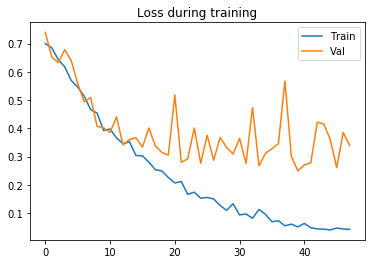

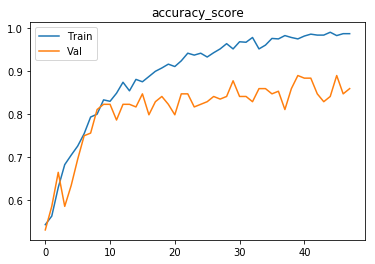

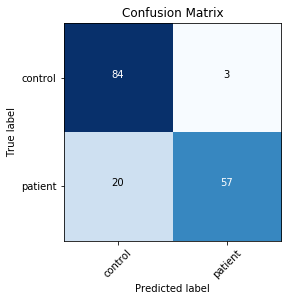

Starting trial 1


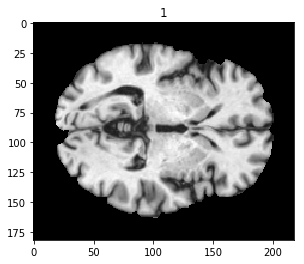

[0,    60] loss: 0.72476
[0,   120] loss: 0.66382
[0,   180] loss: 0.65083
Time elapsed: 0h:1m:48s
train accuracy_score: 58.27 %
val accuracy_score: 64.02 %
Val loss: 0.627353
[1,    60] loss: 0.66077
[1,   120] loss: 0.67609
[1,   180] loss: 0.64333
Time elapsed: 0h:3m:43s
train accuracy_score: 63.15 %
val accuracy_score: 74.39 %
Val loss: 0.571913
[2,    60] loss: 0.62562
[2,   120] loss: 0.58453
[2,   180] loss: 0.55614
Time elapsed: 0h:5m:39s
train accuracy_score: 68.81 %
val accuracy_score: 55.49 %
Val loss: 0.744469
[3,    60] loss: 0.58159
[3,   120] loss: 0.55508
[3,   180] loss: 0.49682
Time elapsed: 0h:7m:34s
train accuracy_score: 72.92 %
val accuracy_score: 76.83 %
Val loss: 0.488682
[4,    60] loss: 0.51449
[4,   120] loss: 0.50233
[4,   180] loss: 0.49534
Time elapsed: 0h:9m:24s
train accuracy_score: 77.03 %
val accuracy_score: 84.15 %
Val loss: 0.399060
[5,    60] loss: 0.46612
[5,   120] loss: 0.49188
[5,   180] loss: 0.44463
Time elapsed: 0h:11m:12s
train accuracy_score

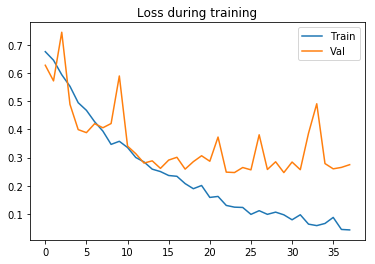

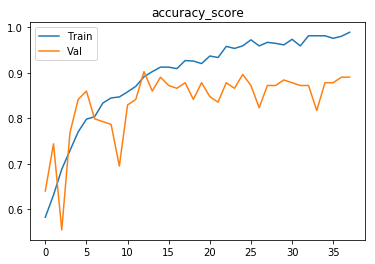

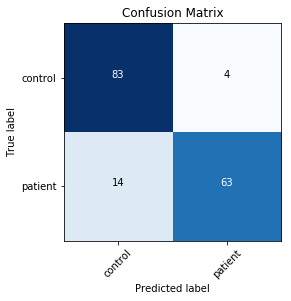

Starting trial 2


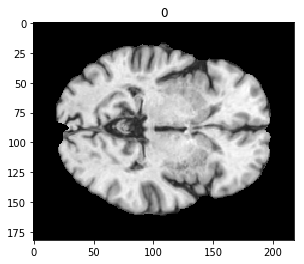

[0,    60] loss: 0.73287
[0,   120] loss: 0.70835
[0,   180] loss: 0.68943
Time elapsed: 0h:1m:46s
train accuracy_score: 55.60 %
val accuracy_score: 54.88 %
Val loss: 0.693230
[1,    60] loss: 0.67606
[1,   120] loss: 0.69425
[1,   180] loss: 0.67336
Time elapsed: 0h:3m:37s
train accuracy_score: 60.04 %
val accuracy_score: 56.71 %
Val loss: 0.668194
[2,    60] loss: 0.63850
[2,   120] loss: 0.66201
[2,   180] loss: 0.66261
Time elapsed: 0h:5m:26s
train accuracy_score: 61.49 %
val accuracy_score: 62.80 %
Val loss: 0.641458
[3,    60] loss: 0.62607
[3,   120] loss: 0.58160
[3,   180] loss: 0.62075
Time elapsed: 0h:7m:14s
train accuracy_score: 67.26 %
val accuracy_score: 56.10 %
Val loss: 0.671933
[4,    60] loss: 0.59784
[4,   120] loss: 0.56039
[4,   180] loss: 0.56649
Time elapsed: 0h:9m:4s
train accuracy_score: 70.70 %
val accuracy_score: 75.00 %
Val loss: 0.537224
[5,    60] loss: 0.58244
[5,   120] loss: 0.54042
[5,   180] loss: 0.54196
Time elapsed: 0h:10m:53s
train accuracy_score:

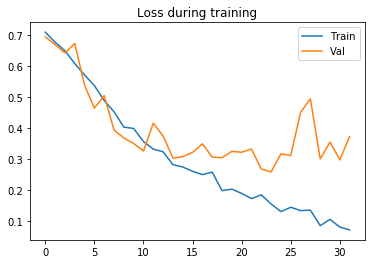

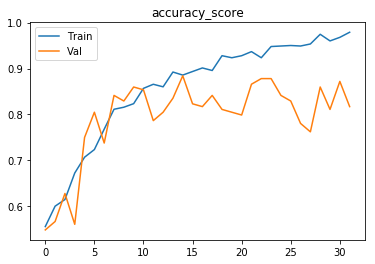

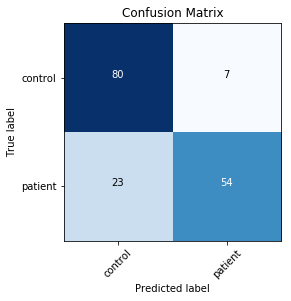

Starting trial 3


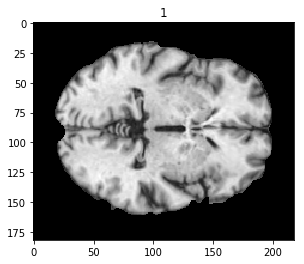

[0,    60] loss: 0.76043
[0,   120] loss: 0.70088
[0,   180] loss: 0.68069
Time elapsed: 0h:1m:46s
train accuracy_score: 56.71 %
val accuracy_score: 57.93 %
Val loss: 0.674258
[1,    60] loss: 0.69595
[1,   120] loss: 0.67809
[1,   180] loss: 0.65089
Time elapsed: 0h:3m:43s
train accuracy_score: 58.49 %
val accuracy_score: 66.46 %
Val loss: 0.651002
[2,    60] loss: 0.67930
[2,   120] loss: 0.63528
[2,   180] loss: 0.62952
Time elapsed: 0h:5m:41s
train accuracy_score: 61.38 %
val accuracy_score: 69.51 %
Val loss: 0.618543
[3,    60] loss: 0.64370
[3,   120] loss: 0.60606
[3,   180] loss: 0.59209
Time elapsed: 0h:7m:46s
train accuracy_score: 67.04 %
val accuracy_score: 75.00 %
Val loss: 0.565305
[4,    60] loss: 0.58243
[4,   120] loss: 0.57107
[4,   180] loss: 0.59491
Time elapsed: 0h:9m:48s
train accuracy_score: 69.37 %
val accuracy_score: 73.78 %
Val loss: 0.539092
[5,    60] loss: 0.61506
[5,   120] loss: 0.52321
[5,   180] loss: 0.55243
Time elapsed: 0h:11m:36s
train accuracy_score

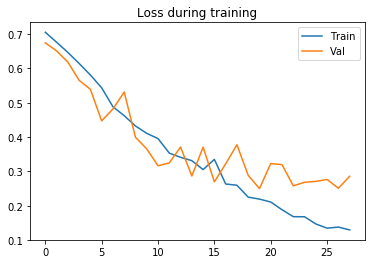

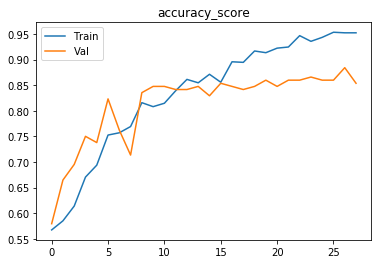

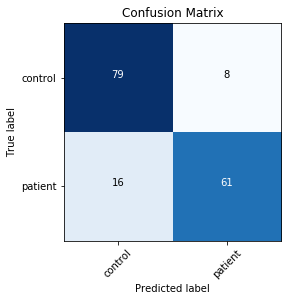

################################
################################
All accuracies: [0.8597560975609756, 0.8902439024390244, 0.8170731707317073, 0.8536585365853658]
0.8551829268292682
0.026004149556756093


In [23]:
fold_metric, models = run(net=net, data=adni_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b,
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

# Start inference

In [20]:
model_path = "/analysis/ritter/projects/AD/Budding_Spectral_Analysis/models/model_final"

In [21]:
# load models
models = []
for i in range(4):
    model_dir = os.path.join(model_path, "repeat_0_cv_fold_{}_BEST_ITERATION.h5".format(i))
    net = ClassificationModel3D()
    net.load_state_dict(torch.load(model_dir))
    models.append(net)

In [22]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [24]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))
            output = net.forward(img)
            pred = torch.argmax(F.softmax(output, dim=1))
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    auc = auc_score(all_labels, all_preds)
    print(balanced_acc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append((balanced_acc, sens, spec, auc))
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))


Fold 0
0.6801150430997602
Fold 1
0.6745091761224844
Fold 2
0.7002669066158063
Fold 3
0.669546424362198
######## Final results ########
          0         1         2         3
0  0.680115  0.749511  0.610719  0.680115
1  0.674509  0.679061  0.669958  0.674509
2  0.700267  0.722114  0.678420  0.700267
3  0.669546  0.653620  0.685472  0.669546
Balanced accuracy mean 68.11 %


In [25]:
quit()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
